In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory

In [2]:
data_dir = "data/train/"

In [3]:
tf.__version__

'2.3.0'

In [4]:
batch_size = 16
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28997 files belonging to 4 classes.
Using 23198 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28997 files belonging to 4 classes.
Using 5799 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['peinture', 'photo', 'sketch', 'text']


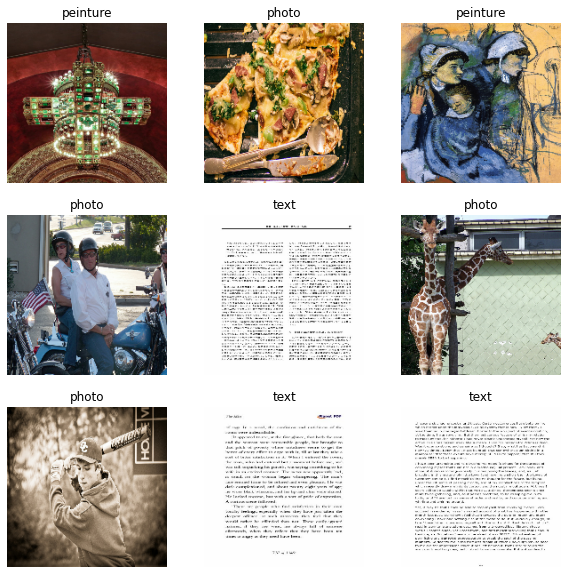

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 180, 180, 3)
(16,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.905266


In [13]:
num_classes = 4

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1450/1450 [==============================] - 43s 29ms/step - loss: 0.1521 - accuracy: 0.9369 - val_loss: 0.2414 - val_accuracy: 0.9074
Epoch 2/10
1450/1450 [==============================] - 42s 29ms/step - loss: 0.1047 - accuracy: 0.9596 - val_loss: 0.2537 - val_accuracy: 0.9119
Epoch 3/10
1450/1450 [==============================] - 42s 29ms/step - loss: 0.0723 - accuracy: 0.9736 - val_loss: 0.3262 - val_accuracy: 0.9091
Epoch 4/10
1450/1450 [==============================] - 43s 29ms/step - loss: 0.0403 - accuracy: 0.9857 - val_loss: 0.3927 - val_accuracy: 0.9081
Epoch 5/10
1450/1450 [==============================] - 43s 29ms/step - loss: 0.0315 - accuracy: 0.9884 - val_loss: 0.5915 - val_accuracy: 0.8755
Epoch 6/10
1450/1450 [==============================] - 42s 29ms/step - loss: 0.0338 - accuracy: 0.9885 - val_loss: 0.4656 - val_accuracy: 0.9058
Epoch 7/10
1450/1450 [==============================] - 42s 29ms/step - loss: 0.0287 - accuracy: 0.9903 - val_loss: 0.4789 -

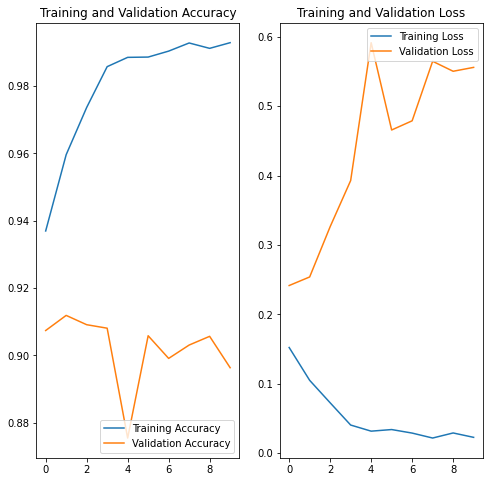

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()